In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [35]:
from sklearn.cluster import DBSCAN

In [13]:
# !pip install ucimlrepo  ## uncomment to install required repository
from ucimlrepo import fetch_ucirepo

In [14]:
wine = fetch_ucirepo(id=109)

In [26]:
X = wine.data.features
X

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [27]:
y = wine.data.targets
y

,class
0,1
1,1
2,1
3,1
4,1
...,...
173,3
174,3
175,3
176,3


In [3]:
wine_df = pd.read_csv('data/wine-clustering.csv')

In [4]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [5]:
wine_df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


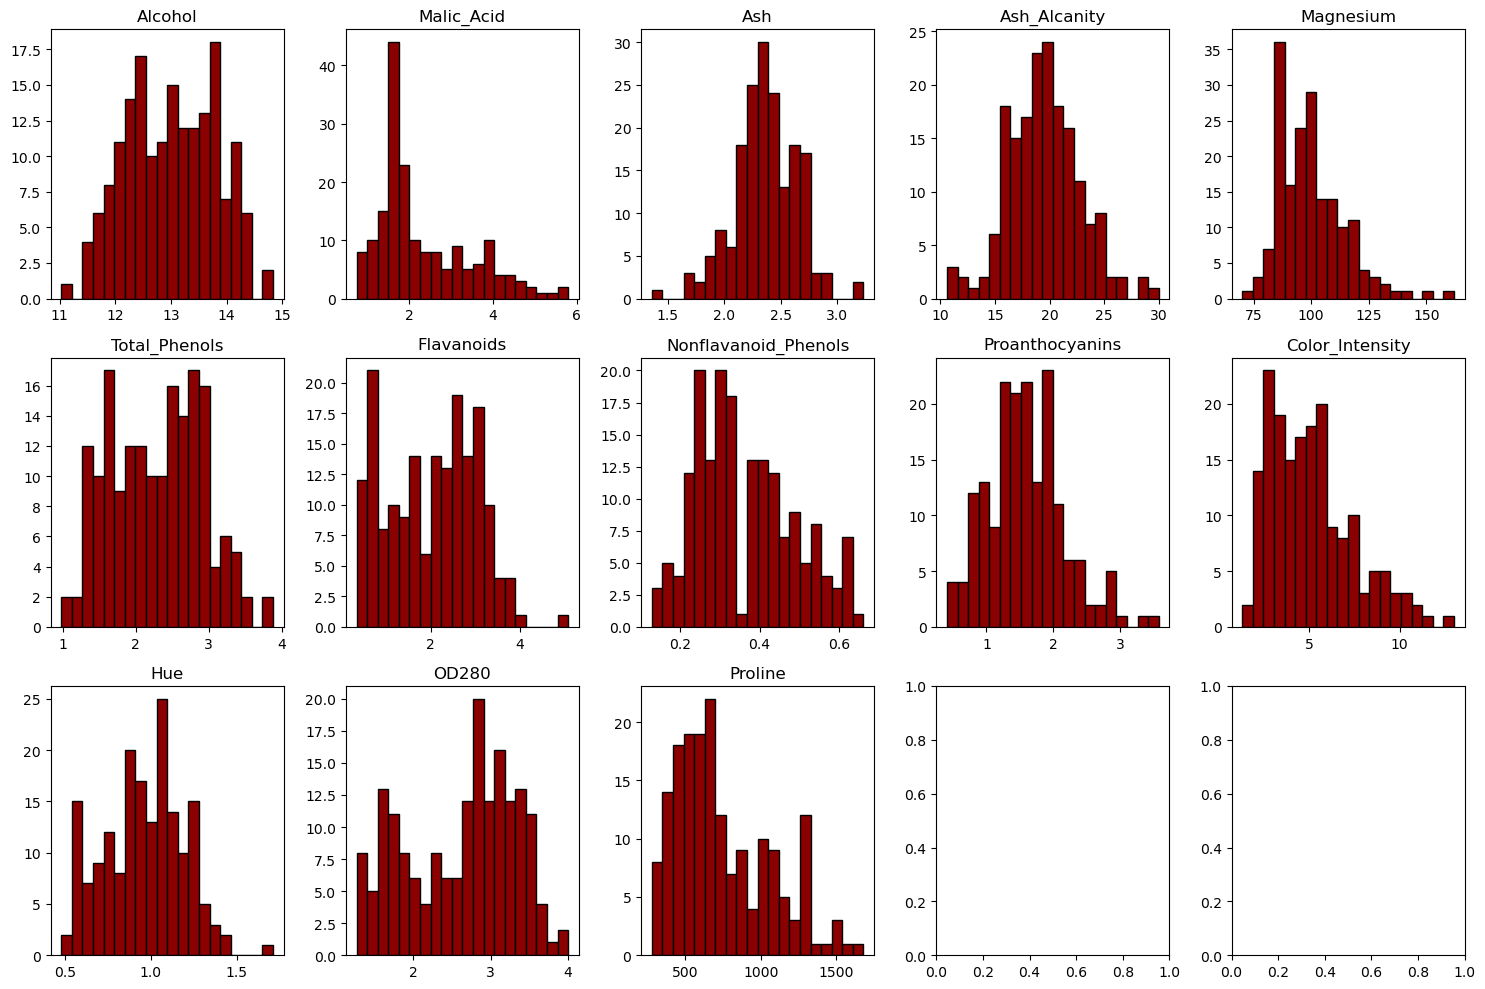

In [38]:
# Set up a 3x5 grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

# Flatten the 2D grid of axes for easy iteration
axes = axes.ravel()

# Plot histograms for each column in the dataset
for i, col in enumerate(wine_df.columns):
    axes[i].hist(wine_df[col], bins=20, color='darkred', edgecolor='black')
    axes[i].set_title(col)

# Adjust layout
plt.tight_layout()
plt.show()

### KMeans Clustering

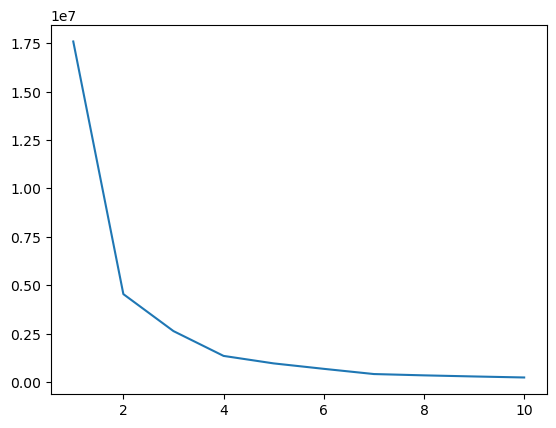

In [11]:
# To find the best clusters with the 'k-means++' model:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=3000, random_state=42)
    kmeans.fit(wine_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.show()

### Hierarchical Clustering

In [24]:
# Normalize the data (Hierarchical clustering is sensitive to feature scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

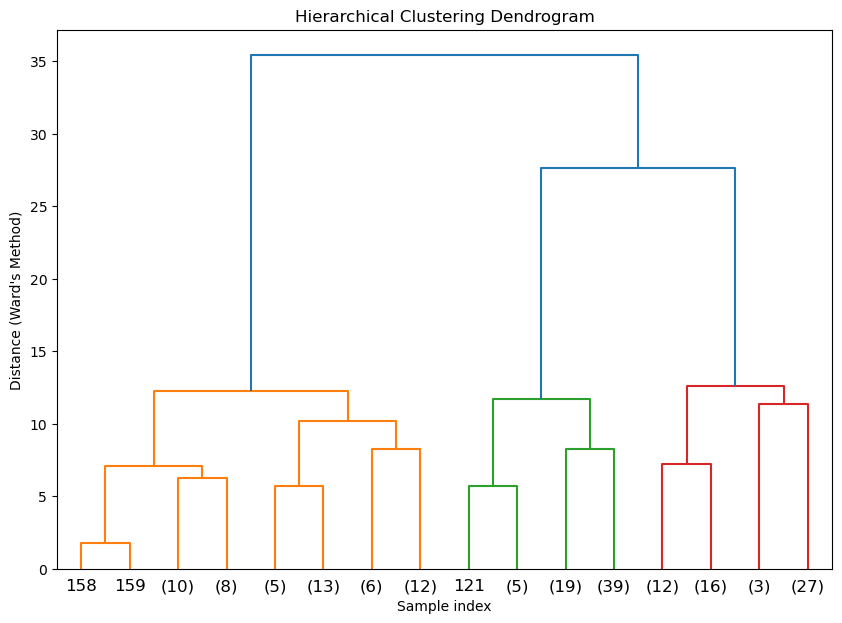

In [28]:
# Compute the linkage matrix (method='ward' is commonly used)
Z = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=3)  # truncate to view only part of the tree
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance (Ward\'s Method)')
plt.show()


In [31]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clusters = agg_clustering.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
X['Cluster'] = clusters

# View the clustered data
print(X.head())



   Alcohol  Malicacid   Ash  Alcalinity_of_ash  Magnesium  Total_phenols  \
0    14.23       1.71  2.43               15.6        127           2.80   
1    13.20       1.78  2.14               11.2        100           2.65   
2    13.16       2.36  2.67               18.6        101           2.80   
3    14.37       1.95  2.50               16.8        113           3.85   
4    13.24       2.59  2.87               21.0        118           2.80   

   Flavanoids  Nonflavanoid_phenols  Proanthocyanins  Color_intensity   Hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   0D280_0D315_of_diluted_wines  Proline  Cluster  
0               

In [34]:
# Define linkage methods and distance metrics
linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'manhattan', 'cosine']  # 'ward' only works with 'euclidean'

# To store results
results = []

# Iterate through all combinations
for linkage in linkage_methods:
    for metric in distance_metrics:
        if linkage == 'ward' and metric != 'euclidean':
            # Ward linkage only works with Euclidean distance
            continue
        
        # Perform Agglomerative Clustering
        agg_clustering = AgglomerativeClustering(n_clusters=3, metric=metric, linkage=linkage)
        
        try:
            clusters = agg_clustering.fit_predict(X_scaled)
            
            # Compute Silhouette Score
            score = silhouette_score(X_scaled, clusters)
            results.append((linkage, metric, score))
            print(f"Linkage: {linkage}, Metric: {metric}, Silhouette Score: {score:.4f}")
        
        except Exception as e:
            print(f"Error with Linkage: {linkage}, Metric: {metric}: {str(e)}")

# Find the best combination based on silhouette score
best_combination = max(results, key=lambda x: x[2])
print(f"\nBest Combination: Linkage: {best_combination[0]}, Metric: {best_combination[1]}, Silhouette Score: {best_combination[2]:.4f}")

Linkage: ward, Metric: euclidean, Silhouette Score: 0.2774
Linkage: complete, Metric: euclidean, Silhouette Score: 0.2038
Linkage: complete, Metric: manhattan, Silhouette Score: 0.1899
Linkage: complete, Metric: cosine, Silhouette Score: 0.2443
Linkage: average, Metric: euclidean, Silhouette Score: 0.1575
Linkage: average, Metric: manhattan, Silhouette Score: 0.2519
Linkage: average, Metric: cosine, Silhouette Score: 0.2645
Linkage: single, Metric: euclidean, Silhouette Score: 0.1827
Linkage: single, Metric: manhattan, Silhouette Score: 0.1980
Linkage: single, Metric: cosine, Silhouette Score: -0.1143

Best Combination: Linkage: ward, Metric: euclidean, Silhouette Score: 0.2774


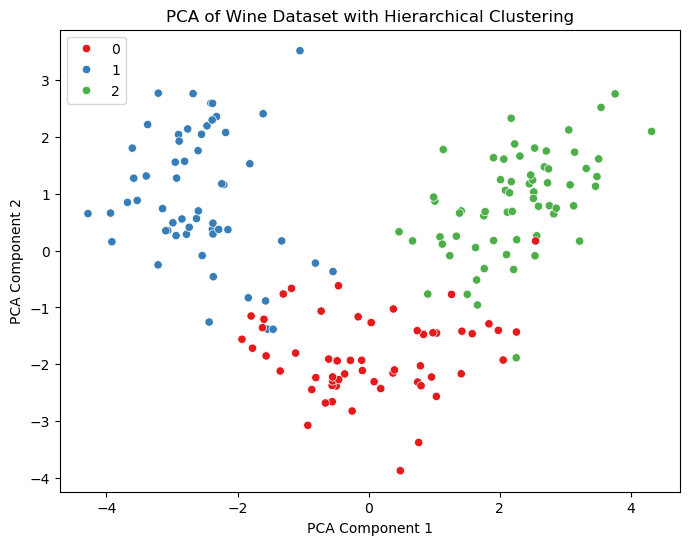

In [32]:
from sklearn.decomposition import PCA
import seaborn as sns

# Perform PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set1')
plt.title('PCA of Wine Dataset with Hierarchical Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


### DBSCAN clustering

Cluster Counts:
-1    178
Name: count, dtype: int64


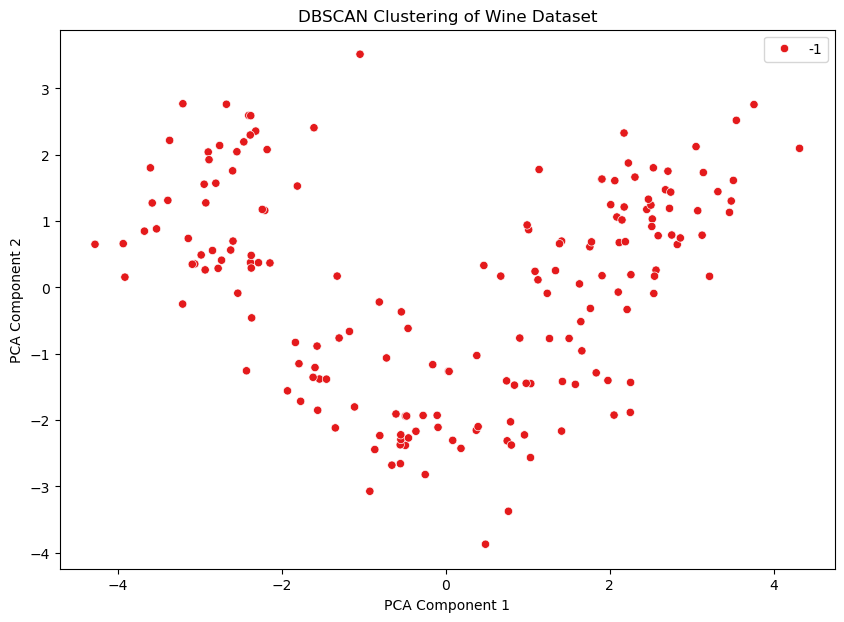

In [37]:
# 2. Extract features (X) and scale the data
X = wine.data.features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Perform DBSCAN clustering
# You can adjust the parameters epsilon (eps) and min_samples based on your data
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can experiment with these parameters
clusters = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the original DataFrame
X['Cluster'] = clusters

# 4. Evaluate and visualize the clusters
# Count of points in each cluster (including noise labeled as -1)
cluster_counts = pd.Series(clusters).value_counts()

print("Cluster Counts:")
print(cluster_counts)

from sklearn.decomposition import PCA

# Perform PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set1', legend='full')
plt.title('DBSCAN Clustering of Wine Dataset')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


An unsupervised machine learning clustering project generally involves several key components or steps. Here’s a breakdown of the main stages:

1. Problem Definition and Objective Setting
Goal: Define the purpose of the clustering project. Common objectives include grouping similar items, customer segmentation, anomaly detection, etc.
Data Understanding: Gain an initial understanding of the data, the domain, and the expected outcome of clustering.
2. Data Collection
Collect or access the data to be clustered. This data could come from databases, web scraping, APIs, or predefined datasets.
3. Data Preprocessing and Cleaning
Handling Missing Values: Decide how to handle missing data (removal, imputation, etc.).
Dealing with Outliers: Identify and either remove or treat outliers.
Scaling and Normalization: Apply techniques like standardization (z-score normalization) or min-max scaling to bring all features to the same scale.
Encoding Categorical Variables: Convert categorical data into numerical form (e.g., one-hot encoding, label encoding).
Feature Selection: Choose relevant features based on their importance, domain knowledge, or statistical tests.
Dimensionality Reduction: Apply techniques like PCA or t-SNE to reduce the dimensionality of the data, if necessary.
4. Exploratory Data Analysis (EDA)
Visualize the data using histograms, scatter plots, and pair plots to understand its structure.
Check for relationships or patterns among features.
Use techniques like correlation matrices or summary statistics to assess the distribution and relationships.
5. Choosing a Clustering Algorithm
The choice of algorithm depends on the nature of the data and the project objective. Common clustering algorithms include:

* K-Means: Suitable for spherical clusters and requires specifying the number of clusters.
* Hierarchical Clustering: Builds a hierarchy of clusters and doesn't require pre-specifying the number of clusters.
* DBSCAN (Density-Based Spatial Clustering): Suitable for identifying clusters of arbitrary shapes, including noise.
* Gaussian Mixture Models (GMM): Assumes that data points are generated from a mixture of several Gaussian distributions.
* Agglomerative Clustering: A type of hierarchical clustering that can handle various linkage criteria.

6. Model Training (Clustering)
Initialization: Set up the clustering algorithm with relevant hyperparameters (e.g., number of clusters in K-Means, distance metric, etc.).
Fitting the Model: Apply the clustering algorithm to your dataset to assign data points to clusters.
7. Cluster Evaluation
Clustering is unsupervised, so evaluation can be tricky. Here are some evaluation methods:

Internal Evaluation Metrics (when ground truth is not available):
Silhouette Score: Measures how similar each point is to its cluster compared to other clusters.
Inertia (K-Means): Measures how tight the clusters are.
Davies-Bouldin Index: Evaluates the ratio of within-cluster scatter to between-cluster separation.


External Evaluation Metrics (if ground truth labels are available):
* Adjusted Rand Index (ARI): Measures how well the clustering matches ground truth labels.
* Normalized Mutual Information (NMI): Measures the similarity between predicted clusters and ground truth labels.
* Elbow Method: Used in K-Means to determine the optimal number of clusters by plotting within-cluster sum of squares.


8. Visualization of Clusters
Scatter Plots or Pair Plots: Visualize clusters in 2D or 3D.
t-SNE or PCA: Visualize high-dimensional clusters in lower dimensions.
Dendrograms: Used in hierarchical clustering to visualize the hierarchy of clusters.
Heatmaps: Used to visualize relationships within clusters, especially with hierarchical clustering.
9. Model Interpretation and Insights
Cluster Profiling: Examine the characteristics of each cluster by comparing feature means, distributions, etc.
Business Interpretation: Relate clusters back to the business objective or problem you're solving.
Anomaly Detection: Clustering can help identify outliers that don’t fit into any cluster.
10. Hyperparameter Tuning
Experiment with different values for hyperparameters (e.g., number of clusters, distance metrics) to improve the clustering.
Use grid search or random search for hyperparameter optimization.
11. Deployment (if necessary)
Integrate the clustering model into production systems if needed (e.g., customer segmentation in a marketing system).
Monitor and Update: Clustering models might require updates as new data comes in.
12. Reporting and Communication
Visualization: Provide visual representations of clusters for better understanding.
Report: Summarize the findings, describe the characteristics of the clusters, and present actionable insights to stakeholders.
Documentation: Ensure that all steps, assumptions, and decisions made during the project are documented.